<a href="https://colab.research.google.com/github/elias9080dm/XenoTox_Colab/blob/main/QSAR_Classification_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Observaciones***

Resuelto.

Solo queda pendiente determinar el mejor modelo para cada receptor






# **QSAR Clasificación Binaria**

Inspirado en el artículo de Kotli et al. (2025), este cuaderno permite construir modelos QSAR binarios sobre datos desbalanceados.

**Incluye:**
- Modelos Random Forest, XGBoost, SVM, KNN
- Balanceo de clases (SMOTE)
- Métrica principal: MCC
- Interpretabilidad con SHAP
- Y-scrambling
- Curva de cobertura
- Dominio de aplicabilidad (Leverage)
- Guardado automático de modelos, gráficas y métricas

## **1. Imports**

In [1]:
# Instalación de librerías necesarias
%pip install pandas numpy scikit-learn scikit-optimize xgboost rdkit shap optuna bayesian-optimization


In [2]:
# Montar drive
from google.colab import drive
import os, sys
from pathlib import Path

drive.mount('/content/drive')

# Crear carpetas
BASE_DIR = "/content/drive/MyDrive/QSAR/xenotox"
os.makedirs(f"{BASE_DIR}/outputs/models", exist_ok=True)
os.makedirs(f"{BASE_DIR}/outputs/plots", exist_ok=True)
os.makedirs(f"{BASE_DIR}/outputs/reports", exist_ok=True)

# Establecer carpeta padre
PROJECT_ROOT = Path("/content/drive/MyDrive/QSAR/xenotox")
sys.path.append(str(PROJECT_ROOT))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# General
import os, shap, joblib
from joblib import Parallel, delayed
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
import warnings
import contextlib, sys
from pathlib import Path

# Curación de RDKit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger


# Machine Learning
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from collections import Counter

# Métricas
from sklearn.metrics import (
    make_scorer, accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, roc_auc_score, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay
)

# Balanceo y pipelines
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from qsar.utils import clean_numeric
from sklearn.feature_selection import VarianceThreshold

# Hiperoptimización
import optuna
from skopt import BayesSearchCV
from skopt.space import Real as SkReal, Integer as SkInteger, Categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer
from sklearn.base import clone, BaseEstimator, TransformerMixin


## **2. Configuración**

In [4]:
target_name = 'ahr' # 'ahr', 'pxr', 'car' Los nombres de los archivos deben ser {target_name}_ligands.csv
model_name = 'xgb'  # 'rf', 'xgb', 'svm', 'knn'
use_stacking = True
use_hyperopt = True
hyperopt_method = 'optuna'  # 'optuna'
n_jobs = -1  # Utilizar todos los CPU disponibles
random_state = 42
proba_thresholds = [round(x, 2) for x in np.arange(0.1, 1.0, 0.1)]

## **3. Curación de base de datos**

In [5]:
# Apagar logs de RDKit
RDLogger.DisableLog('rdApp.*')

# Función de curación
def curate_csv_data(csv_path, smiles_col="SMILES", activity_col="Activity"):
    df_raw = pd.read_csv(csv_path)
    initial_count = len(df_raw)

    # 1. Eliminar NaNs
    df = df_raw.dropna(subset=[smiles_col, activity_col]).copy()

    # 2. Convertir a molécula RDKit
    df["mol"] = df[smiles_col].apply(Chem.MolFromSmiles)
    df = df[df["mol"].notnull()].copy()

    # 3. Estandarización
    lfc = rdMolStandardize.LargestFragmentChooser()
    normalizer = rdMolStandardize.Normalizer()
    reionizer = rdMolStandardize.Reionizer()
    uncharger = rdMolStandardize.Uncharger()

    def standardize(mol):
        try:
            mol = lfc.choose(mol)
            mol = normalizer.normalize(mol)
            mol = reionizer.reionize(mol)
            mol = uncharger.uncharge(mol)
            return mol
        except:
            return None

    df["mol_std"] = df["mol"].apply(standardize)
    df = df[df["mol_std"].notnull()].copy()

    # 4. Generar SMILES canónico estandarizado
    df["SMILES_std"] = df["mol_std"].apply(Chem.MolToSmiles)

    # 5. Eliminar duplicados
    df = df.drop_duplicates(subset="SMILES_std").copy()

    # 6. Resetear índices y renombrar columnas estándar
    df = df[[activity_col, "SMILES_std"]].rename(columns={"SMILES_std": "SMILES"})
    df = df.reset_index(drop=True)

    final_count = len(df)
    print(f"Curación completa: {final_count} moléculas válidas (de {initial_count} iniciales).")
    return df

# Usar la función de curación en el archivo CSV correspondiente
out_path = f"{BASE_DIR}/ligands/{target_name}_ligands.csv"
df = curate_csv_data(out_path)
display(df.head())


Curación completa: 7485 moléculas válidas (de 7487 iniciales).


,Activity,SMILES
0,Active,Clc1cc2c(cc1Cl)Oc1cc(Cl)c(Cl)cc1O2
1,Active,O=C(O)c1cccc(-c2noc(-c3ccccc3F)n2)c1
2,Active,Cc1nc(-c2ccc(OCC(C)C)c(C#N)c2)sc1C(=O)O
3,Active,COc1c2ccoc2cc2oc(=O)ccc12
4,Active,c1ccc2cc3c(cc2c1)-c1cccc2cccc-3c12


## **4. Cálculo de descriptores**

In [6]:
# 1. Función de cálculo
def calcular_descriptores(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return [func(mol) for _, func in Descriptors._descList]

# 2. Configuración de hilos (Ajustado al número real de CPUs disponibles)
from psutil import cpu_count
n_cores = cpu_count()

print(f"Iniciando cálculo en paralelo con {n_cores} núcleos...")

# 3. Ejecución paralela
smiles_list = df['SMILES'].tolist()
resultados = Parallel(n_jobs=n_cores)(
    delayed(calcular_descriptores)(s) for s in tqdm(smiles_list, desc="Progreso RDKit")
)

# 4. Post-procesamiento y Alineación
# Creamos un Series temporal para usar la lógica de dropna() y mantener índices
desc_series = pd.Series(resultados, index=df.index)
desc_clean = desc_series.dropna()

# 5. Crear X como DataFrame
feature_names = [name for name, _ in Descriptors._descList]
X = pd.DataFrame(desc_clean.tolist(), index=desc_clean.index, columns=feature_names)

# 6. Etiquetas y DataFrame original alineados
y = df.loc[desc_clean.index, "Activity"].values
df_curated = df.loc[desc_clean.index].reset_index(drop=True)

# 7. Reporte final
print(f"\n✅ Proceso completado.")
print(f"Dataset: {target_name} | Moléculas finales: {len(X)} | Descriptores: {X.shape[1]}")

# Guardar CSV curado
os.makedirs("outputs/reports", exist_ok=True)
out_path = f"outputs/reports/{target_name}_curated_df.csv"
df_curated.to_csv(out_path, index=False)
print(f"Archivo guardado en: {out_path}")

Iniciando cálculo en paralelo con 2 núcleos...


Progreso RDKit: 100%|██████████| 7485/7485 [01:33<00:00, 79.77it/s]



✅ Proceso completado.
Dataset: ahr | Moléculas finales: 7485 | Descriptores: 217
Archivo guardado en: outputs/reports/ahr_curated_df.csv


### 4.1 Visualizar distribución de clases

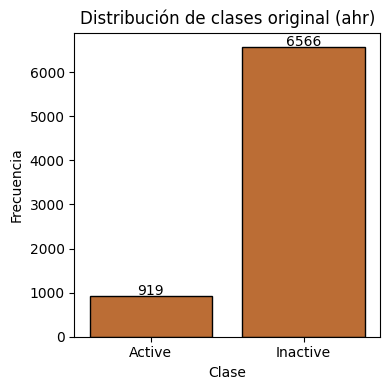

Histograma guardado en: /content/drive/MyDrive/QSAR/xenotox/outputs/plots/ahr_initial_class_distribution.png


In [7]:
# Histograma de clases en la base de datos curada
activity_col = "Activity"
plt.figure(figsize=(4, 4))
ax = sns.countplot(x=activity_col, data=df, edgecolor='black', color='chocolate', legend=False)
plt.title(f"Distribución de clases original ({target_name})")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{int(height)}", (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', xytext=(0, -1), textcoords='offset points')

plt.tight_layout()

# Guardar figura
out_path = f"{BASE_DIR}/outputs/plots/{target_name}_initial_class_distribution.png"
plt.savefig(out_path, dpi=300)
plt.show()
print(f"Histograma guardado en: {out_path}")


## **5. División estratificada**

In [8]:
# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=random_state)

# Convertir X_train y X_test a DataFrame para mantener columnas e índices
X_train = pd.DataFrame(X_train, columns=X.columns, index=X.index[X_train.index])
X_test = pd.DataFrame(X_test, columns=X.columns, index=X.index[X_test.index])

## **7. Hiperoptimización Optuna**

In [9]:
# === Función segura de StratifiedKFold ===
def safe_stratified_kfold(y, max_folds=5, shuffle=True, random_state=42):
    counts = Counter(y)
    min_class_count = min(counts.values())
    n_splits = min(max_folds, min_class_count)
    if n_splits < 2:
        raise ValueError(f"No se puede usar validación cruzada: solo hay {min_class_count} muestras en la clase menor.")
    return StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

# === BUILD PIPELINE ===
def build_pipeline(model, smote_k): # Pipeline de imblearn que maneja bien SMOTE
    return Pipeline([
        ("clean", FunctionTransformer(clean_numeric, validate=False)),
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("smote", SMOTE(k_neighbors=smote_k, random_state=random_state)),
        ("model", model)
    ])

# === MAIN OPTIMIZATION FUNCTION ===
def optimize_model(X, y_encoded, model_name, hyperopt_method):

    # Cálculo de smote_k (y_encoded ya debe estar codificado numéricamente)
    min_class = min(Counter(y_encoded).values())
    smote_k = max(1, min(min_class - 1, 5))

    # Selección del modelo base
    if model_name == "xgb":
        base_model = XGBClassifier(eval_metric="logloss", random_state=random_state, n_jobs=n_jobs, tree_method="hist")

    elif model_name == "rf":
        base_model = RandomForestClassifier(n_jobs=n_jobs, random_state=random_state)

    elif model_name == "svm":
        base_model = SVC(probability=True, random_state=random_state, kernel='rbf')

    elif model_name == "knn":
        base_model = KNeighborsClassifier(n_jobs=n_jobs)

    else:
        raise ValueError(f"Modelo no soportado: {model_name}")

    # Pipeline y validación cruzada
    pipe = build_pipeline(base_model, smote_k)
    cv = safe_stratified_kfold(y_encoded, max_folds=5, random_state=random_state)

    # Solo Optuna para simplificar
    if hyperopt_method != "optuna":
        raise ValueError("Solo se soporta 'optuna' en esta versión simplificada")

    def objective(trial):
        # Definir espacios de búsqueda específicos para cada modelo
        if model_name == "xgb":
            params = {
                "model__n_estimators": trial.suggest_int("model__n_estimators", 300, 800),
                "model__max_depth": trial.suggest_int("model__max_depth", 3, 7),
                "model__learning_rate": trial.suggest_float("model__learning_rate", 0.01, 0.2, log=True),
                "model__subsample": trial.suggest_float("model__subsample", 0.6, 0.9),
                "model__colsample_bytree": trial.suggest_float("model__colsample_bytree", 0.6, 0.9),
                "model__gamma": trial.suggest_float("model__gamma", 0, 0.3),
                "model__min_child_weight": trial.suggest_int("model__min_child_weight", 1, 10),
                "model__reg_alpha": trial.suggest_float("model__reg_alpha", 1e-5, 1, log=True),
                "model__reg_lambda": trial.suggest_float("model__reg_lambda", 1e-3, 10, log=True),
            }
        elif model_name == "rf":
            params = {
                "model__n_estimators": trial.suggest_int("model__n_estimators", 300, 800),
                "model__max_depth": trial.suggest_int("model__max_depth", 8, 20),
                "model__min_samples_leaf": trial.suggest_int("model__min_samples_leaf", 1, 5),
                "model__min_samples_split": trial.suggest_int("model__min_samples_split", 2, 10),
                "model__max_features": trial.suggest_categorical("model__max_features", ["sqrt", "log2"]),
            }
        elif model_name == "svm":
            params = {
                "model__C": trial.suggest_float("model__C", 0.01, 100, log=True),
                "model__gamma": trial.suggest_float("model__gamma", 1e-5, 1, log=True),
            }
        elif model_name == "knn":
            params = {
                "model__n_neighbors": trial.suggest_int("model__n_neighbors", 3, 35),
                "model__weights": trial.suggest_categorical("model__weights", ["distance", "uniform"]),
                "model__p": trial.suggest_int("model__p", 1, 2),
            }
        trial_pipe = build_pipeline(clone(base_model), smote_k)
        trial_pipe.set_params(**params)

        # Hacer scorer para cv
        mcc_scorer = make_scorer(matthews_corrcoef)

        scores = cross_val_score(
            trial_pipe,
            X,
            y_encoded,
            scoring=mcc_scorer,
            cv=cv,
            n_jobs=n_jobs
        )

        return scores.mean()

    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=random_state),
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=5)) # Detener automaticamente trials malos
    if model_name == "svm":
        study.optimize(objective, n_trials=50)

    else:
        study.optimize(objective, n_trials=30)

    # Entrenar modelo final
    final_pipe = build_pipeline(base_model, smote_k)
    final_pipe.set_params(**study.best_params)
    final_pipe.fit(X, y_encoded)
    # Guardar mejores parámetros y mejor MCC
    final_pipe.best_params_ = study.best_params
    final_pipe.best_score_ = study.best_value



    return final_pipe

In [10]:
# Entrenamiento del StackingClassifier

def train_stacking_model(
    X_train,
    y_train_enc,
    hyperopt_method="optuna",
    n_jobs=1,
    random_state=42
):
    """
    Entrena un StackingClassifier usando modelos base optimizados
    con la función optimize_model existente.
    """

    base_model_names = ["xgb", "rf", "svm", "knn"]
    estimators = []

    print("Entrenando modelos base para stacking:")

    for name in base_model_names:
        print(f"  → Optimizando {name.upper()} con Optuna")
        model_pipe = optimize_model(
            X_train,
            y_train_enc,
            model_name=name,
            hyperopt_method=hyperopt_method
        )
        estimators.append((name, model_pipe))

    # CV del stacking (usar misma lógica segura)
    try:
        cv_stack = safe_stratified_kfold(y_train_enc, max_folds=5, random_state=random_state)
    except ValueError:
        cv_stack = 2  # fallback seguro

    # Meta-modelo
    meta_model = LogisticRegression(
        penalty="l2",
        C=0.1,
        class_weight="balanced",
        max_iter=1000,
        solver="lbfgs",
        random_state=random_state
    )

    print("Entrenando StackingClassifier final")

    stacking_model = StackingClassifier(
        estimators=estimators,
        final_estimator=meta_model,
        stack_method="predict_proba",
        cv=cv_stack,
        n_jobs=n_jobs,
        passthrough=False
    )

    stacking_model.fit(X_train, y_train_enc)

    return stacking_model


## **8. Entrenamiento y stacking**

In [11]:
# Silenciar warnings innecesarias
warnings.filterwarnings("ignore", category=UserWarning, module="multiprocessing")
warnings.filterwarnings("ignore", category=UserWarning, module="pkg_resources")

# Detección de tamaño de dataset
min_class = min(Counter(y_train).values()) # y_train aquí es el original sin codificar ni SMOTE
n_splits = min(5, min_class)
do_cv = len(X_train) >= 20 and n_splits >= 2

print(f"Dataset info: Total train = {len(X_train)} | Min class = {min_class} | n_splits = {n_splits}")
if not do_cv:
    print("Dataset pequeño: se omite validación cruzada y se reduce k_neighbors en SMOTE.")

# Codificar etiquetas (use a specific name for the global LabelEncoder)
global_label_encoder = LabelEncoder()
y_train_enc = global_label_encoder.fit_transform(y_train)   # ["Active","Inactive"] → [0,1]
y_test_enc  = global_label_encoder.transform(y_test)

# ==========================================================
#       ENTRENAMIENTO DEL MODELO
# ==========================================================
if use_stacking:
  print("Entrenando StackingClassifier final")
  final_model = train_stacking_model(X_train, y_train_enc)

  reference_pipeline = final_model.estimators_[0][1]
  # Preprocesar X_train exactamente igual que en predicción antes de guardarla
  X_train_clean = reference_pipeline.named_steps["clean"].transform(X_train)
  X_train_imp = reference_pipeline.named_steps["imputer"].transform(X_train_clean)
  X_train_preprocessed = reference_pipeline.named_steps["scaler"].transform(X_train_imp)

  model_components = {
      'model': final_model,
      'label_encoder': global_label_encoder,
      'X_train_preprocessed': X_train_preprocessed,
      'y_train': y_train,
      'feature_names': feature_names,
      'target_name': target_name,
      'model_type': 'stacking',
      }
  model_path = f"{BASE_DIR}/outputs/models/best_model_{target_name}_StackingClassifier_{hyperopt_method}.pkl"
  joblib.dump(model_components, model_path)
  print(f"Modelo y componentes guardados en: {model_path}")

else:
  print(f"Entrenando modelo {model_name} individual")
  final_model = optimize_model(X_train, y_train_enc, model_name, hyperopt_method)

  # Preprocesar X_train exactamente igual que en predicción antes de guardarla
  X_train_clean = final_model.named_steps["clean"].transform(X_train)
  X_train_imp = final_model.named_steps["imputer"].transform(X_train_clean)
  X_train_preprocessed = final_model.named_steps["scaler"].transform(X_train_imp)

  # Guardado del modelo entrenado y componentes necesarios / importantes
  model_components = {
      'model': final_model,
      'label_encoder': global_label_encoder,
      'X_train_preprocessed': X_train_preprocessed,
      'y_train': y_train,
      'feature_names': feature_names,
      'target_name': target_name,
      'model_type': model_name,
      }
  model_path = f"{BASE_DIR}/outputs/models/best_model_{target_name}_{model_name}_{hyperopt_method}.pkl"
  joblib.dump(model_components, model_path)
  print(f"Modelo y componentes guardados en: {model_path}")

[I 2026-01-01 19:11:23,066] A new study created in memory with name: no-name-3c0568e3-8481-445e-bd79-e95093ff53f2


Dataset info: Total train = 5613 | Min class = 689 | n_splits = 5
Entrenando StackingClassifier final
Entrenando modelos base para stacking:
  → Optimizando XGB con Optuna


[I 2026-01-01 19:12:27,255] Trial 0 finished with value: 0.4759080628769299 and parameters: {'model__n_estimators': 487, 'model__max_depth': 7, 'model__learning_rate': 0.08960785365368121, 'model__subsample': 0.779597545259111, 'model__colsample_bytree': 0.6468055921327309, 'model__gamma': 0.04679835610086079, 'model__min_child_weight': 1, 'model__reg_alpha': 0.21423021757741043, 'model__reg_lambda': 0.2537815508265665}. Best is trial 0 with value: 0.4759080628769299.
[I 2026-01-01 19:12:54,830] Trial 1 finished with value: 0.46450184805482947 and parameters: {'model__n_estimators': 654, 'model__max_depth': 3, 'model__learning_rate': 0.18276027831785724, 'model__subsample': 0.8497327922401265, 'model__colsample_bytree': 0.6637017332034828, 'model__gamma': 0.05454749016213018, 'model__min_child_weight': 2, 'model__reg_alpha': 0.00033205591037519585, 'model__reg_lambda': 0.12561043700013558}. Best is trial 0 with value: 0.4759080628769299.
[I 2026-01-01 19:13:24,258] Trial 2 finished wit

KeyboardInterrupt: 

## **9. Métricas y curvas**

In [ ]:
# FUNCIÓN DE EVALUACIÓN DEL MODELO, MÉTRICAS Y CURVAS
def compute_metrics(final_model, X_test, y_test, model_name, target_name, label_encoder):

    # === 1. Predicciones ===
    y_pred = final_model.predict(X_test)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_proba = final_model.predict_proba(X_test)[:, 1]

    # === 2. Métricas ===
    acc  = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)

    # === 3. Guardar métricas en DataFrame ===
    metrics_df = pd.DataFrame([{
        "Model": model_name,
        "Target": target_name,
        "Accuracy": acc,
        "Bal_Accuracy": bal_acc,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1_score": f1,
        "MCC": mcc,
    }])

    if use_stacking:
        metrics_path = f"{BASE_DIR}/outputs/reports/metrics_{target_name}_stacking.csv"
    else:
        metrics_path = f"{BASE_DIR}/outputs/reports/metrics_{target_name}_{model_name}.csv"

    metrics_df.to_csv(metrics_path, index=False)
    print(f"[OK] Métricas guardadas en: {metrics_path}")

    # Mostrar DataFrame
    display(metrics_df)

    return {
        "metrics_df": metrics_df,
        "confusion_matrix": cm,
        "y_pred": y_pred,
        "y_pred_labels": y_pred_labels,
        "y_proba": y_proba
    }


In [ ]:
# RESULTADOS DE LA EVALUACIÓN
results = compute_metrics(
    final_model=final_model,
    X_test=X_test,
    y_test=y_test_enc,
    model_name=model_name,
    target_name=target_name,
    label_encoder=global_label_encoder # Use global_label_encoder
)
print("Evaluación completada.")

## **10. Interpretabilidad SHAP**

modificar la variable name y utilizar model_name en su lugar

In [ ]:
import shap
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

print(f"Interpretabilidad SHAP para: {model_name} - {target_name}\n")

# ==========================================================
#       PROCESAMIENTO SHAP
# ==========================================================

def process_model_shap(model, name, X_data, max_samples=200):
    """Procesa SHAP para un modelo individual"""
    try:
        print(f"--- Procesando: {name} ---")
        X_shap = X_data[:max_samples]
        X_shap_arr = X_shap.values if isinstance(X_shap, pd.DataFrame) else X_shap

        # Determinar tipo de explainer
        model_type = type(model).__name__.lower()
        tree_models = ['xgb', 'rf']
        is_tree_based = any(tree in model_type for tree in tree_models)

        # Crear explainer
        if is_tree_based:
            try:
                explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
                shap_values = explainer(X_shap_arr)
                print("✓ TreeExplainer")
            except:
                explainer = shap.Explainer(model.predict_proba, X_train)
                shap_values = explainer(X_shap_arr)
                print("✓ Explainer (fallback)")
        else:
            explainer = shap.Explainer(model.predict_proba, X_train)
            shap_values = explainer(X_shap_arr)
            print("✓ Explainer")

        # Procesar valores SHAP
        vals = np.array(shap_values.values)
        shap_vals = vals[..., 1] if vals.ndim == 3 else vals

        # Ajustar dimensiones si es necesario
        if shap_vals.shape[1] != len(feature_names):
            shap_vals = shap_vals[:, :len(feature_names)]

        # Generar gráfico y CSV
        plt.figure(figsize=(8, 12))
        shap.summary_plot(shap_vals, X_shap_arr, feature_names=feature_names, show=False)
        plt.tight_layout()
        plt.savefig(f"{BASE_DIR}/outputs/plots/shap_{target_name}_{name}.png", dpi=300)
        plt.show()
        plt.close()

        # Exportar importancias
        importance_df = pd.DataFrame({
            "Descriptor": feature_names,
            "Mean_Abs_SHAP": np.abs(shap_vals).mean(axis=0)
        }).sort_values("Mean_Abs_SHAP", ascending=False)

        importance_df.to_csv(f"{BASE_DIR}/outputs/plots/shap_importance_{target_name}_{name}.csv", index=False)
        print(f"✓ Gráfico y CSV guardados para {name}\n")

    except Exception as e:
        print(f"✗ Error en {name}: {e}\n")

#--------------------------------------------------------------
# Procesar todos los modelos del StackingClassifier uno por uno
def get_model_components(classifier):
    """Obtiene componentes individuales del clasificador"""
    if hasattr(classifier, 'named_estimators_') and classifier.named_estimators_:
        models = list(classifier.named_estimators_.items())
        if hasattr(classifier, 'final_estimator_'):
            models.append(('final_estimator', classifier.final_estimator_))
        return models
    return [('individual_model', classifier)]
# Ejecutar procesamiento
for component_name, model in get_model_components(final_model):
    process_model_shap(model, component_name, X_test)

#---------------------------------------------------------------
# Procesar el StackingClassifier como caja negra
if use_stacking:
    print(f"\nInterpretabilidad SHAP para el StackingClassifier como caja negra: {target_name}\n")
    # El final_model ya contendrá el StackingClassifier si use_stacking es True
    process_model_shap(final_model, 'StackingClassifier_BlackBox', X_test)
else:
    print("El StackingClassifier no se utilizó, omitiendo la interpretación SHAP de caja negra.")

In [ ]:
print(feature_names)

## **11. Y-Scrambling**

In [ ]:
tqdm.pandas()

# Y-Scrambling
scores_scramble = []
for _ in tqdm(range(20), desc="Y-Scrambling"):
    # Encode the scrambled labels before fitting using the global_label_encoder
    y_scrambled_encoded = global_label_encoder.transform(np.random.permutation(y_train))
    final_model.fit(X_train, y_scrambled_encoded)
    # y_test_enc is already encoded, so it can be used directly for prediction and metric calculation
    y_pred_scramble = final_model.predict(X_test)
    scores_scramble.append(matthews_corrcoef(y_test_enc, y_pred_scramble))

yscramble_results_df = pd.DataFrame({'MCC': scores_scramble})
yscramble_results_df
# Guardar DataFrame con las 20 iteraciones
yscramble_results_df.to_csv(f"{BASE_DIR}/outputs/reports/yscramble_{target_name}_{model_name}.csv", index=False)

In [ ]:
yscramble_results_df

In [ ]:
# Resultados
mean_yscramble_mcc = yscramble_results_df['MCC'].mean()
std_yscramble_mcc = yscramble_results_df['MCC'].std()
real_mcc = results['metrics_df']['MCC'].iloc[0]

print(f"Media de MCC de Y-Scrambling: {mean_yscramble_mcc:.4f}")
print(f"Desviación estándar de MCC de Y-Scrambling: {std_yscramble_mcc:.4f}")
print(f"MCC real del modelo: {real_mcc:.4f}")

# Gráfica

plt.figure(figsize=(6, 5))
sns.histplot(yscramble_results_df['MCC'], color='skyblue', label='Y-Scrambled MCCs')
plt.axvline(mean_yscramble_mcc, color='orange', linestyle='--', label=f'Mean Y-Scrambled MCC ({mean_yscramble_mcc:.4f})')
plt.axvline(real_mcc, color='red', linestyle='-', label=f'Real MCC ({real_mcc:.4f})')

plt.title(f'Real MCC vs. Y-Scrambled MCCs ({target_name} - {model_name})')
plt.xlabel('Matthews Correlation Coefficient (MCC)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plot_path = f"{BASE_DIR}/outputs/plots/yscramble_comparison_{target_name}_{model_name}.png"
plt.savefig(plot_path, dpi=300)
plt.show()
print(f"[OK] Gráfico de comparación de Y-Scrambling guardado en: {plot_path}")

## **12. Dominio de Aplicabilidad (AD)**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Transform X_train y X_test usando los pasos de preprocesamiento del pipeline entrenado
# Excluir SMOTE para este cálculo, ya que crea muestras sintéticas
preprocessor = Pipeline([
    ("clean", final_model.named_steps['clean']),
    ("imputer", final_model.named_steps['imputer']),
    ("scaler", final_model.named_steps['scaler'])
])

X_train_processed_for_ad = preprocessor.fit_transform(X_train) # Fit and transform X_train
X_test_processed_for_ad = preprocessor.transform(X_test) # Transform X_test

# Dominio de Aplicabilidad: Williams Plot (Leverage)
# Usar datos preprocesados para el cálculo de la matriz Hat
# Añadir un pequeño término de regularización a X_train_processed_for_ad.T @ X_train_processed_for_ad
# para evitar problemas de singularidad, que podría ser la causa del "SVD did not converge"
# Esta es una práctica común al calcular la inversa/pseudo-inversa para el leverage.
num_features = X_train_processed_for_ad.shape[1]
epsilon = 1e-6 # Pequeño término de regularización

covariance_matrix_inv = np.linalg.pinv(X_train_processed_for_ad.T @ X_train_processed_for_ad + epsilon * np.identity(num_features))


hat_matrix = X_test_processed_for_ad @ covariance_matrix_inv @ X_test_processed_for_ad.T
leverage = np.diag(hat_matrix)

h_star = 3 * (num_features + 1) / X_train_processed_for_ad.shape[0] # Usar conteo de entrenamiento procesado

plt.figure(figsize=(8, 6))

# Obtener los valores codificados para 'Active' e 'Inactive'
active_encoded = global_label_encoder.transform(['Active'])[0]
inactive_encoded = global_label_encoder.transform(['Inactive'])[0]

# Plotear los puntos 'Active' (verde) e 'Inactive' (rojo) por separado para asignar etiquetas de leyenda directas
plt.scatter(leverage[y_test_enc == active_encoded], results['y_proba'][y_test_enc == active_encoded],
            color='green', alpha=0.6, label='Active')
plt.scatter(leverage[y_test_enc == inactive_encoded], results['y_proba'][y_test_enc == inactive_encoded],
            color='darkred', alpha=0.6, label='Inactive')

# Añadir líneas de referencia
plt.axhline(0.5, color='gray', linestyle='--', linewidth=0.8, label='Probabilidad de corte (0.5)')
plt.axvline(h_star, color='red', linestyle='--', label=f'Umbral de Leverage (h*={h_star:.2f})')

plt.xlabel('Leverage (h_ii)')
plt.ylabel('Probabilidad predicha de clase "Activa"')
plt.title(f'Diagrama de Williams - Dominio de Aplicabilidad ({target_name} - {model_name})')
plt.legend() # Llama a legend sin argumentos para que use las etiquetas de los scatters
plt.grid(True, alpha=0.3)

plot_path = f"{BASE_DIR}/outputs/plots/ad_williams_{target_name}_{model_name}.png"
plt.savefig(plot_path, dpi=300)
plt.show()
plt.close()

print(f"[OK] Diagrama de Williams guardado en: {plot_path}")

In [ ]:
print(global_label_encoder.classes_)

La paleta de colores `coolwarm` se utiliza para la visualización en el gráfico de Williams. Esta paleta asigna colores fríos (como el azul) a los valores más bajos y colores cálidos (como el rojo) a los valores más altos. Una vez que se ejecute la celda anterior, podremos determinar qué etiqueta corresponde a qué color.

## **13. Predicción externa**

In [ ]:
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.MolStandardize import rdMolStandardize
from IPython.display import HTML
import io
import base64

def mol_to_base64_image(mol, width=200, height=200):
    if mol is None:
        return None
    try:
        img = Draw.MolToImage(mol, size=(width, height))
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        return base64.b64encode(buffered.getvalue()).decode("utf-8")
    except Exception as e:
        print(f"Error generating image for molecule: {e}")
        return None

def predict_from_smiles(smiles_list):
    processed_data = []
    original_smiles = []
    molecule_images = []
    valid_mols = []
    invalid_smiles_list = []

    for s in smiles_list:
        mol = Chem.MolFromSmiles(s)
        if mol is not None:
            # Standardize molecule before descriptor calculation and image generation
            lfc = rdMolStandardize.LargestFragmentChooser()
            normalizer = rdMolStandardize.Normalizer()
            reionizer = rdMolStandardize.Reionizer()
            uncharger = rdMolStandardize.Uncharger()

            def standardize(m):
                try:
                    m = lfc.choose(m)
                    m = normalizer.normalize(m)
                    m = reionizer.reionize(m)
                    m = uncharger.uncharge(m)
                    return m
                except:
                    return None

            mol_std = standardize(mol)

            if mol_std is not None:
                smiles_std = Chem.MolToSmiles(mol_std)
                descriptors = calcular_descriptores(smiles_std)

                if all(d is not None for d in descriptors):
                    processed_data.append(descriptors)
                    original_smiles.append(s)
                    valid_mols.append(mol_std)
                    molecule_images.append(mol_to_base64_image(mol_std))
                else:
                    invalid_smiles_list.append(s)
            else:
                invalid_smiles_list.append(s)
        else:
            invalid_smiles_list.append(s)

    predictions_df = pd.DataFrame(columns=['SMILES', 'Activity_Prediction', 'Probability', 'Leverage', 'AD_Flag', 'Molecule_Image'])
    if processed_data:
        raw_X_ext = np.array(processed_data)

        # Apply preprocessing steps (clean, imputer, scaler) from the trained pipeline to raw_X_ext
        X_ext_preprocessed = final_model.named_steps['clean'].transform(raw_X_ext)
        X_ext_preprocessed = final_model.named_steps['imputer'].transform(X_ext_preprocessed)
        X_ext_preprocessed = final_model.named_steps['scaler'].transform(X_ext_preprocessed)

        # Predictions
        y_proba = final_model.predict_proba(X_ext_preprocessed)[:, 1]
        y_pred_encoded = final_model.predict(X_ext_preprocessed)
        y_pred_labels = global_label_encoder.inverse_transform(y_pred_encoded)

        # Dominio de Aplicabilidad (Leverage)
        try:
            if not isinstance(X_train, pd.DataFrame):
                X_train_df = pd.DataFrame(X_train)
            else:
                X_train_df = X_train

            num_samples_train = X_train_df.shape[0]
            num_features_train = X_train_df.shape[1]
            # Usar X_train_processed_for_ad para el cálculo del leverage si está disponible y es correcto
            # Si no, recalcularlo a partir de X_train_df
            if 'X_train_processed_for_ad' in globals() and X_train_processed_for_ad is not None:
                 # Asegurarse de que el preprocesador está entrenado con el X_train correcto
                X_train_for_ad = preprocessor.fit_transform(X_train_df)
            else:
                # En caso de que X_train_processed_for_ad no esté disponible (por ejemplo, primera ejecución o kernel reset)
                # es mejor usar los pasos del preprocesador del final_model directamente en X_train_df
                X_train_for_ad = preprocessor.fit_transform(X_train_df)

            # Recalcular la matriz de covarianza inversa para la estabilidad numérica
            num_features_for_ad = X_train_for_ad.shape[1]
            epsilon = 1e-6
            covariance_matrix_inv_for_ad = np.linalg.pinv(X_train_for_ad.T @ X_train_for_ad + epsilon * np.identity(num_features_for_ad))

            h_star_recalculated = 3 * (num_features_for_ad + 1) / X_train_for_ad.shape[0]

            hat = np.diag(X_ext_preprocessed @ covariance_matrix_inv_for_ad @ X_ext_preprocessed.T)
            ad_flag = ['Inside AD' if h < h_star_recalculated else 'Outside AD' for h in hat]
        except Exception as e:
            print(f"Error in AD calculation: {e}")
            hat = [np.nan] * len(original_smiles)
            ad_flag = ['Error in AD'] * len(original_smiles)

        # Create DataFrame with results
        predictions_df = pd.DataFrame({
            'SMILES': original_smiles,
            'Activity_Prediction': y_pred_labels,
            'Probability': y_proba,
            'Leverage': hat,
            'AD_Flag': ad_flag,
            'Molecule_Image': molecule_images
        })

    invalid_df = pd.DataFrame({
        'Invalid_SMILES': invalid_smiles_list,
        'Reason': ['Invalid SMILES or Descriptor Calculation Failed'] * len(invalid_smiles_list)
    }) if invalid_smiles_list else pd.DataFrame(columns=['Invalid_SMILES', 'Reason'])

    return predictions_df, invalid_df

# Helper function to display DataFrame with images
def display_df_with_images(df):
    if 'Molecule_Image' in df.columns:
        html_output = df.to_html(escape=False, formatters=dict(Molecule_Image=lambda img: f'<img src="data:image/png;base64,{img}">'))
        display(HTML(html_output))
    else:
        display(df)

# Predicción de ejemplo
predictions, invalid_smiles = predict_from_smiles(['CC(=O)Nc1ccccc1C', 'invalid_smiles_string', '1', 'c1ccccc1O'])

print("\n--- Predicciones para SMILES válidos ---")
display_df_with_images(predictions)

print("\n--- SMILES inválidos o con error de cálculo de descriptores ---")
display(invalid_smiles)


# Task
Set the `use_stacking` variable to `True` in cell `cf78e0ac`, then update the `train_stacking_model` call in cell `ecd64325` by removing the `BASE_DIR` and `use_existing_models` arguments, and finally execute cell `ecd64325` to train and save the `StackingClassifier` model.

## Update StackingClassifier call

### Subtask:
Modify the call to `train_stacking_model` in cell `ecd64325` to remove the `BASE_DIR` and `use_existing_models` arguments, aligning it with the function's definition in cell `FjLBPBVgsoli`.


**Reasoning**:
The first instruction is to change the value of `use_stacking` to `True` in cell `cf78e0ac`.

